In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%cd ../content/gdrive/MyDrive/SOMDrive/bacteriaID/

/content/gdrive/MyDrive/SOMDrive/bacteriaID


In [ ]:
%ls

config.py                              modelo_rdfc_entrenado_ft.pkl
data/                                  modelo_rdfc_entrenado.pkl
df_scores.csv                          modelo_rdfc_pca_entrenado_ft.pkl
IdentificacionBacterias.ipynb          modelo_rdfc_pca_entrenado.pkl
modelo_dtc_entrenado_ft.pkl            modelo_regr_entrenado_ft.pkl
modelo_dtc_entrenado.pkl               modelo_regr_entrenado.pkl
modelo_dtc_pca_entrenado_ft.pkl        modelo_regr_pca_entrenado_ft.pkl
modelo_dtc_pca_entrenado.pkl           modelo_regr_pca_entrenado.pkl
modelo_model_cnn0_entrenado_ft.h5      modelo_svm_entrenado.pkl
modelo_model_cnn0_entrenado.h5         modelo_svm_pca_entrenado_ft.pkl
modelo_model_cnn1_entrenado.h5         modelo_svm_pca_entrenado.pkl
modelo_model_cnn2_entrenado_ft.h5      __pycache__/
modelo_model_cnn2_entrenado.h5         tree1.dot
modelo_model_restnet_entrenado_ft.h5   tree1.png
modelo_model_restnet_entrenado.h5      tree2.dot
modelo_model_restnet_entrenado_old.h5  tree2.png


In [ ]:
from google.colab import files
files.upload()

# Identificación rápida de bacterias patógenas mediante espectroscopia Raman y aprendizaje profundo

# Espectroscopía Raman

O. Sala, "Capítulo 1: Fundamentos de cspectroscopia Raman", Fundamentos da espectroscopía Raman e no in-fravermelho, pp. 10-34, 1996. [Enlace](https://www.tdx.cat/bitstream/handle/10803/6887/03Rpp03de11.pdf)

El análisis mediante espectroscopía Raman se basa en el examen de luz dispersada por un material al incidir sobre él un haz de luz monocromático. 

La luz dispersada proporciona informaicón sobre la composiión molecular de la muestra. Las frecuencias Raman son características de la naturaleza química y del estado físico de la muestra y son independientes de la readiación incidente.


El espectro Raman representa la intensidad óptica dispersada en función del número de onda normalizado al que se produce. Número de onda es una magnitud proporcinal a la frecuencia e inversamente proporcional a la longitud de onda, se expresa en cm-1.


La probabilidad de que ocurran transferencias de energía que dan lugar a la dispersión Raman Stokes es mayor que la de la dispersión Raman anti-Stokes. La intensidad de la dispersión Raman Stokes es del orden de 100 veces superior a la de la dispersión Raman anti-Stokes. Habitualmente sse trabaja midiendo sólo el efecto Stokes, parte positiva del eje.



## Carga de datos

In [ ]:
import numpy as np
from numpy import argmax
import collections
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
from config import STRAINS, ORDER, ATCC_GROUPINGS, antibiotics, ab_order
from sklearn import  linear_model, model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  
from sklearn import tree
from sklearn.svm import SVC
from sklearn.externals import joblib 
from subprocess import check_call
from IPython.display import Image as PImage
import keras
from keras.layers import Input, Add, Conv1D, BatchNormalization, Activation, Dense, Flatten, Dropout, AveragePooling1D
from keras.initializers import glorot_uniform
from keras.models import Model,Sequential 
import pandas as pd

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# cargamos los datos del ficherro de refererencia y vemos su tamaño y tipo de dato
X = np.load('./data/X_reference.npy')
y = np.load('./data/y_reference.npy')
print(X.shape, y.shape)
print(type(X), type(y))

(60000, 1000) (60000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
print(y)

[ 0.  0.  0. ... 29. 29. 29.]


<BarContainer object of 30 artists>

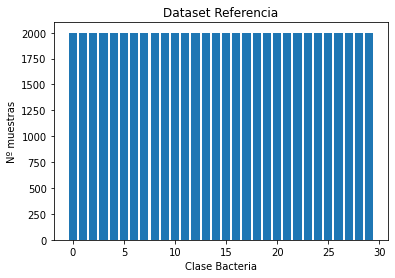

In [ ]:
# las muestras aparecen ordenadas por tipo de bacteria del 0 al 29
# mostramos cuántos datos hay para cada tipo de bacteria
w =collections.Counter(y)

plt.xlabel('Clase Bacteria')
plt.ylabel('Nº muestras')
plt.title('Dataset Referencia')
plt.bar(w.keys(), w.values())

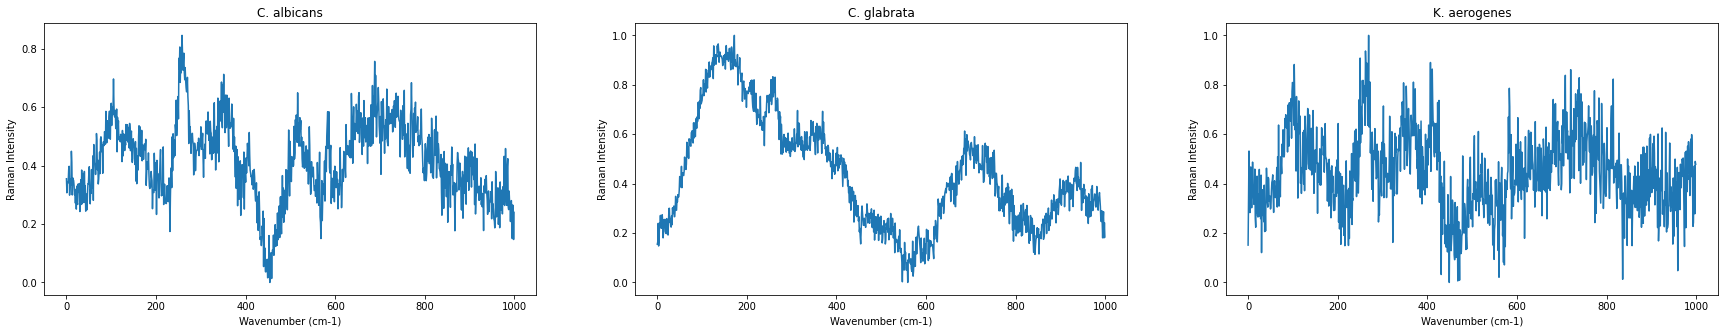

In [ ]:
# Mostramos la gráfica para las primeras muestras de los tres primeros tipos
figure =plt.gcf()
figure.set_size_inches(30,5)

plt.subplot(131)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Raman Intensity')
plt.title(STRAINS[y[0]])
plt.plot(X[0])
#plt.show() 
plt.subplot(132)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Raman Intensity')
plt.title(STRAINS[y[2000]])
plt.plot(X[2000])
#plt.show() 
plt.subplot(133)
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Raman Intensity')
plt.title(STRAINS[y[4000]])
plt.plot(X[4000])
plt.show() 

In [ ]:
# cargamos los datos del ficherro de refinamiento y vemos su tamaño y tipo de dato
X_ft = np.load('./data/X_finetune.npy')
y_ft = np.load('./data/y_finetune.npy')
print(X_ft.shape, y_ft.shape)
print(type(X_ft), type(y_ft))

(3000, 1000) (3000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
# cargamos los datos del ficherro de test y vemos su tamaño y tipo de dato
X_test = np.load('./data/X_test.npy')
y_test = np.load('./data/y_test.npy')
print(X_test.shape, y_test.shape)
print(type(X_test), type(y_test))

(3000, 1000) (3000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Datos de Entrenamiento y Validacion

In [ ]:
# datos de entrenamiento del dataset de referencia
X_tr, X_val, y_tr, y_val=train_test_split(X, y, test_size=0.2, random_state=12345)

In [ ]:
# datos de entrenamiento del dataset de fineTune
X_ft_tr, X_ft_val, y_ft_tr, y_ft_val=train_test_split(X_ft, y_ft, test_size=0.2, random_state=23451)

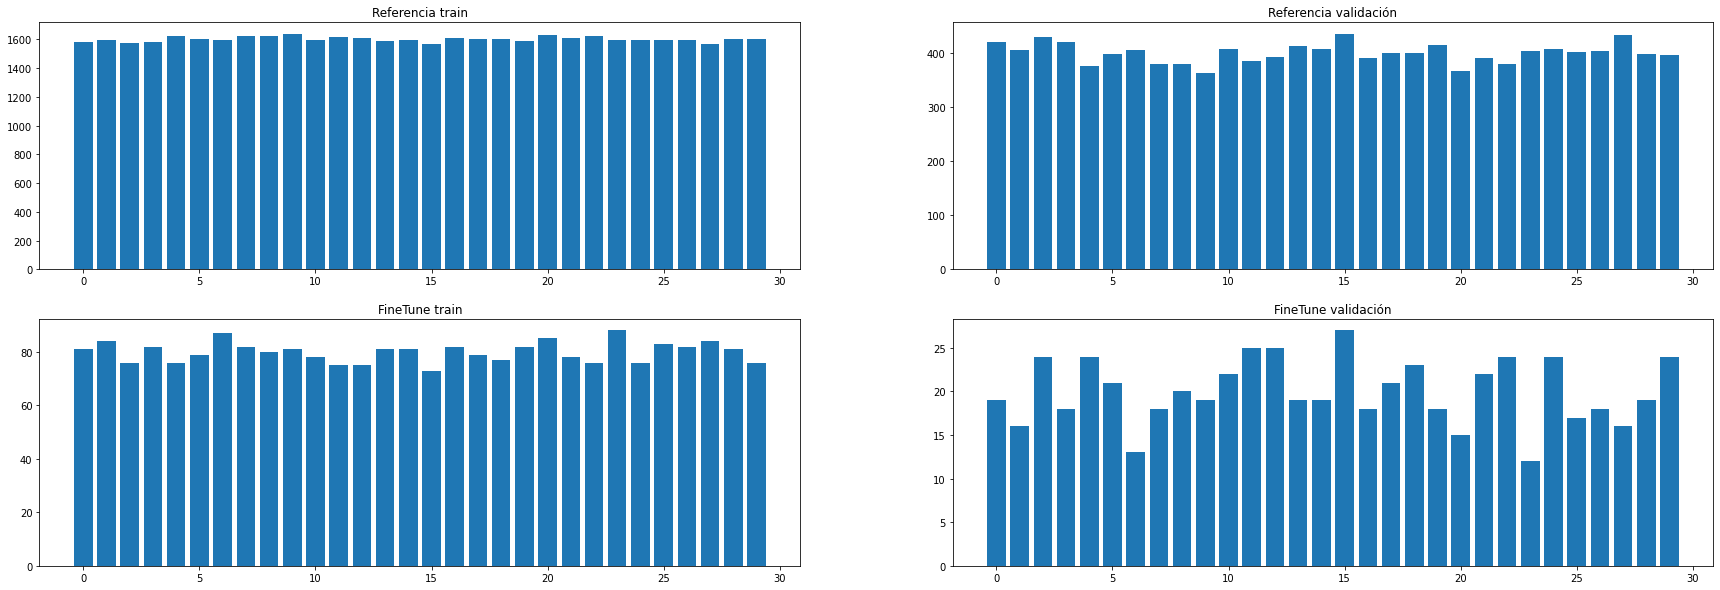

In [ ]:
figure =plt.gcf()
figure.set_size_inches(30,10)

plt.xlabel('Clase Bacteria')
plt.ylabel('Nº muestras')
plt.subplot(221)
plt.title('Referencia train')
w =collections.Counter(y_tr)
plt.bar(w.keys(), w.values())
plt.subplot(222)
plt.title('Referencia validación')
w =collections.Counter(y_val)
plt.bar(w.keys(), w.values())
plt.subplot(223)
plt.title('FineTune train')
w =collections.Counter(y_ft_tr)
plt.bar(w.keys(), w.values())
plt.subplot(224)
plt.title('FineTune validación')
w =collections.Counter(y_ft_val)
plt.bar(w.keys(), w.values())
plt.show() 

In [ ]:
# hacemos reducción de dimensionalidad utilizando PCA como se indica en el estudio, pasando de 1000 a 50 carcaterísticas
pca = PCA(n_components=50)
X_reduced_tr = pca.fit_transform(X_tr)
X_reduced_val = pca.fit_transform(X_val)
X_reduced_ft_tr = pca.fit_transform(X_ft_tr)
X_reduced_ft_val = pca.fit_transform(X_ft_val)
X_reduced_test = pca.fit_transform(X_test)

## Generación del modelo Regresión Logística.

### Regresión Logística con PCA

In [ ]:
name='Logistic Regression + PCA'

In [ ]:
# definimos una regresión logística + PCA
regr_pca = linear_model.LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
# hacemos validación cruzada
regr_pca.fit(X_reduced_tr,y_tr)
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
rlpca_results = model_selection.cross_val_score(regr_pca, X_reduced_tr, y_tr, cv=kfold, scoring='accuracy')
joblib.dump(regr_pca, 'modelo_regr_pca_entrenado.pkl') # guardamos el modelo entrenado
rlpca_tr_acc = rlpca_results.mean()
msg = "%s: %f (%f)" % (name, rlpca_tr_acc, rlpca_results.std())
print(msg)

In [ ]:
# cargamos el modelo en caso de tenerlo almacenado y mostramos resultados
regr_pca = joblib.load('modelo_regr_pca_entrenado.pkl') 
rlpca_tr_acc = regr_pca.score(X_reduced_tr,y_tr)
print("%s %s: (%f)" % (name, ' train ',rlpca_tr_acc))

Logistic Regression + PCA  train : (0.834271)


In [ ]:
# hacemos las predicciones con los datos de validación
y_val_rlpca_pred = regr_pca.predict(X_reduced_val)
rlpca_val_acc = accuracy_score(y_val, y_val_rlpca_pred)
print("%s %s: (%f)" % (name, ' validación ',rlpca_val_acc))


Logistic Regression + PCA  validación : (0.552000)


In [ ]:
# hacemos predicciones con los datos de ajuste fino pero entrenando con parte de ellos y validación con el resto
regr_pca.fit(X_reduced_ft_tr,y_ft_tr)
regr_pca.score(X_reduced_ft_tr,y_ft_tr)
seed = 7
kfold_ft = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
rlpca_results = model_selection.cross_val_score(regr_pca, X_reduced_ft_tr, y_ft_tr, cv=kfold_ft, scoring='accuracy')
joblib.dump(regr_pca, 'modelo_regr_pca_entrenado_ft.pkl') # guardamos el modelo entrenado
rlpca_ft_tr_acc = rlpca_results.mean()
msg = "%s %s: %f (%f)" % (name,' FineTune ', rlpca_ft_tr_acc, rlpca_results.std())
print(msg)

Logistic Regression + PCA  FineTune : 0.911667 (0.010172)


In [ ]:
# cargamos el modelo en caso de tenerlo almacenado
regr_pca = joblib.load('modelo_regr_pca_entrenado_ft.pkl') 

# hacemos las predicciones con los datos de entrenamiento de fineTune
y_ft_tr_rlpca_pred = regr_pca.predict(X_reduced_ft_tr)
rlpca_ft_tr_acc = accuracy_score(y_ft_tr, y_ft_tr_rlpca_pred)
print("%s %s: (%f)" % (name, ' FineTune Train ',rlpca_ft_tr_acc))

Logistic Regression + PCA  FineTune Train : (0.878333)


In [ ]:
# hacemos las predicciones con los datos de validación de fineTune
y_ft_val_rlpca_pred = regr_pca.predict(X_reduced_ft_val)
rlpca_ft_val_acc = accuracy_score(y_ft_val, y_ft_val_rlpca_pred)
print("%s %s: (%f)" % (name, ' FineTune validación ',rlpca_ft_val_acc))

Logistic Regression + PCA  FineTune validación : (0.550000)


In [ ]:
# hacemos las predicciones con los datos de test
y_test_rlpca_pred = regr_pca.predict(X_reduced_test)
rlpca_test_acc = accuracy_score(y_test, y_test_rlpca_pred)
print("%s %s: (%f)" % (name, ' test ',rlpca_test_acc))


Logistic Regression + PCA  test : (0.223667)


### Regresión logistica

In [ ]:
name='Logistic Regression'

In [ ]:
# definimos una regresión logística
regr = linear_model.LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
# entrenamos el modelo y mostramos información de los resultados del entrenamiento
regr.fit(X_tr,y_tr)
rl_tr_acc = regr.score(X_tr,y_tr)
joblib.dump(regr, 'modelo_regr_entrenado.pkl') # guardamos el modelo entrenado
print("%s %s: %f " % (name,' Train ', rl_tr_acc))

In [ ]:
# cargamos el modelo en caso de tenerlo almacenado
regr = joblib.load('modelo_regr_entrenado.pkl') 

# calculamos el accuracy para los datos de entrenamiento
rl_tr_acc = regr.score(X_tr,y_tr)
print("%s %s: %f " % (name,' Train ', rl_tr_acc))

Logistic Regression + PCA  Train : 0.971167 


In [ ]:
# hacemos las predicciones con los datos de validación
y_val_rl_pred = regr.predict(X_val)
rl_val_acc =accuracy_score(y_val, y_val_rl_pred)
print("%s %s: %f " % (name, ' validación ', rl_val_acc))

Logistic Regression + PCA  validación : 0.912667 


In [ ]:
# hacemos predicciones con los datos de ajuste fino pero entrenando con parte de ellos y validación con el resto
regr.fit(X_ft_tr,y_ft_tr)
joblib.dump(regr, 'modelo_regr_entrenado_ft.pkl') # guardamos el modelo entrenado
# calculamos el accuracy para los datos de entrenamiento de fintune
rl_ft_tr_acc = regr.score(X_ft_tr,y_ft_tr)
msg = "%s %s: %f " % (name, ' FineTune ',rl_ft_tr_acc)
print(msg)

In [ ]:
# cargamos el modelo en caso de tenerlo almacenado
regr = joblib.load('modelo_regr_entrenado_ft.pkl') 

# calculamos el accuracy para los datos de entrnamiento de fineTune
rl_ft_tr_acc = regr.score(X_ft_tr,y_ft_tr)
msg = "%s %s: %f " % (name, ' FineTune ',rl_ft_tr_acc)
print(msg)

Logistic Regression + PCA  FineTune : 1.000000 


In [ ]:
# hacemos las predicciones con los datos de validación
y_ft_val_rl_pred = regr.predict(X_ft_val)
rl_ft_val_acc = accuracy_score(y_ft_val, y_ft_val_rl_pred)
print("%s %s: %f " % (name, ' FineTune validación ',rl_ft_val_acc))

Logistic Regression + PCA  FineTune validación : 0.898333 


In [ ]:
# hacemos las predicciones con los datos de test
y_test_rl_pred = regr.predict(X_test)
rl_test_acc = accuracy_score(y_test, y_test_rl_pred)
print("%s %s: %f " % (name, ' Test ',rl_test_acc))


Logistic Regression + PCA  Test : 0.782000 


## Generar modelo con TreeClassifier

### TreeCalsifier con PCA

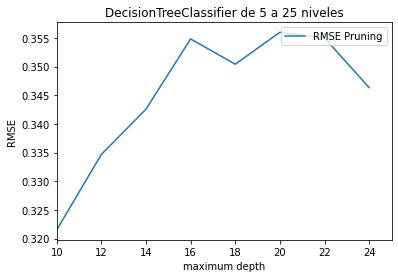

In [ ]:
# Variamos la profundidad para ver cuál es el más eficiente

RMSE_array = []
depth_min = 10
depth_max = 25

for i in range(depth_min, depth_max, 2):
    # regresion tree
    dtrpca_i = DecisionTreeClassifier(criterion= "gini" ,random_state=0, max_depth=i, min_samples_split=10)
    # entrenamiento
    dtrpca_i.fit(X_reduced_tr, y_tr)
    # predicción
    y_dtrpca_i_pred = dtrpca_i.predict(X_reduced_val)
    RMSE_array.append((i, round(accuracy_score(y_val, y_dtrpca_i_pred),5))) 

    
    
xs, ys = zip(*RMSE_array)

plt.title('DecisionTreeClassifier de 5 a 25 niveles')
plt.plot(xs, ys, label='RMSE Pruning')
plt.xlim(depth_min, depth_max)
plt.xlabel("maximum depth")
plt.ylabel("RMSE")
plt.legend(loc="upper right")
plt.show()

In [ ]:
name='DecisionTreeClassifier + PCA'

In [ ]:
# classification tree
dtc_pca=DecisionTreeClassifier(criterion= "gini",random_state=0, max_depth=22, min_samples_split=10)


In [ ]:
# entrenamiento
dtc_pca=dtc_pca.fit(X_reduced_tr,y_tr)
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
dtcpca_results = model_selection.cross_val_score(dtc_pca, X_reduced_tr, y_tr, cv=kfold, scoring='accuracy')
joblib.dump(dtc_pca, 'modelo_dtc_pca_entrenado.pkl') # guardamos el modelo entrenado
y_dtcpca_tr_pred=dtc_pca.predict(X_reduced_tr)
dtcpca_tr_acc = accuracy_score(y_tr, y_dtcpca_tr_pred)
print('%s %s: %f'%(name,' Train ', dtcpca_tr_acc))

In [ ]:
# cargamos el modelo en caso de tenerlo almacenado
dtc_pca = joblib.load('modelo_dtc_pca_entrenado.pkl')
y_dtcpca_tr_pred=dtc_pca.predict(X_reduced_tr)
dtcpca_tr_acc = accuracy_score(y_tr, y_dtcpca_tr_pred)
print('%s %s: %f'%(name,' Train ', dtcpca_tr_acc))

Logistic Regression + PCA  Train : 0.784729


In [ ]:
# predicción de datos de validación
y_val_dtcpca_pred=dtc_pca.predict(X_reduced_val)
dtcpca_val_acc = accuracy_score(y_val, y_val_dtcpca_pred)
print('%s %s: %f'%(name,' Validación ', dtcpca_val_acc))
#print('Classification report:\n', classification_report(y_val, y_val_dtcpca_pred))

Logistic Regression + PCA  Validación : 0.377583


In [ ]:
# hacemos predicciones con los datos de ajuste fino pero entrenando con parte de ellos y validación con el resto
dtc_pca.fit(X_reduced_ft_tr,y_ft_tr)
seed = 7
kfold_ft = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
dtcpca_results = model_selection.cross_val_score(dtc_pca, X_reduced_ft_tr, y_ft_tr, cv=kfold_ft, scoring='accuracy')
joblib.dump(dtc_pca, 'modelo_dtc_pca_entrenado_ft.pkl')  # guardamos el modelo entrenado
dtcpca_ft_tr_acc = dtcpca_results.mean()
msg = "%s %s: %f (%f)" % (name, ' FineTune Train ', dtcpca_ft_tr_acc, dtcpca_results.std())
print(msg)

DecisionTreeClassifier + PCA  FineTune Train : 0.708750 (0.025580)


In [ ]:
# cargamos el modelo en caso de tenerlo almacenado
dtc_pca = joblib.load('modelo_dtc_pca_entrenado_ft.pkl') 

# predecimos para los datos de entrenamiento para ajuste fino
y_ft_tr_dtcpca_pred=dtc_pca.predict(X_reduced_ft_tr)
dtcpca_ft_tr_acc = accuracy_score(y_ft_tr, y_ft_tr_dtcpca_pred)
print('%s %s: %f'%(name,' FineTune Train ', dtcpca_ft_tr_acc))

Logistic Regression + PCA  FineTune Train : 0.843750


In [ ]:
# predecimos para los datos de validación para ajuste fino
y_ft_val_dtcpca_pred=dtc_pca.predict(X_reduced_ft_val)
dtcpca_ft_val_acc = accuracy_score(y_ft_val, y_ft_val_dtcpca_pred)
print('%s %s: %f'%(name,' FineTune Validacion ', dtcpca_ft_val_acc))

Logistic Regression + PCA  FineTune Validacion : 0.490000


In [ ]:
# predecimos para los datos de test
y_test_dtcpca_pred=dtc_pca.predict(X_reduced_test)
dtcpca_test_acc = accuracy_score(y_test, y_test_dtcpca_pred)
print('%s %s: %f'%(name,' Test ', dtcpca_test_acc))

Logistic Regression + PCA  Test : 0.147333


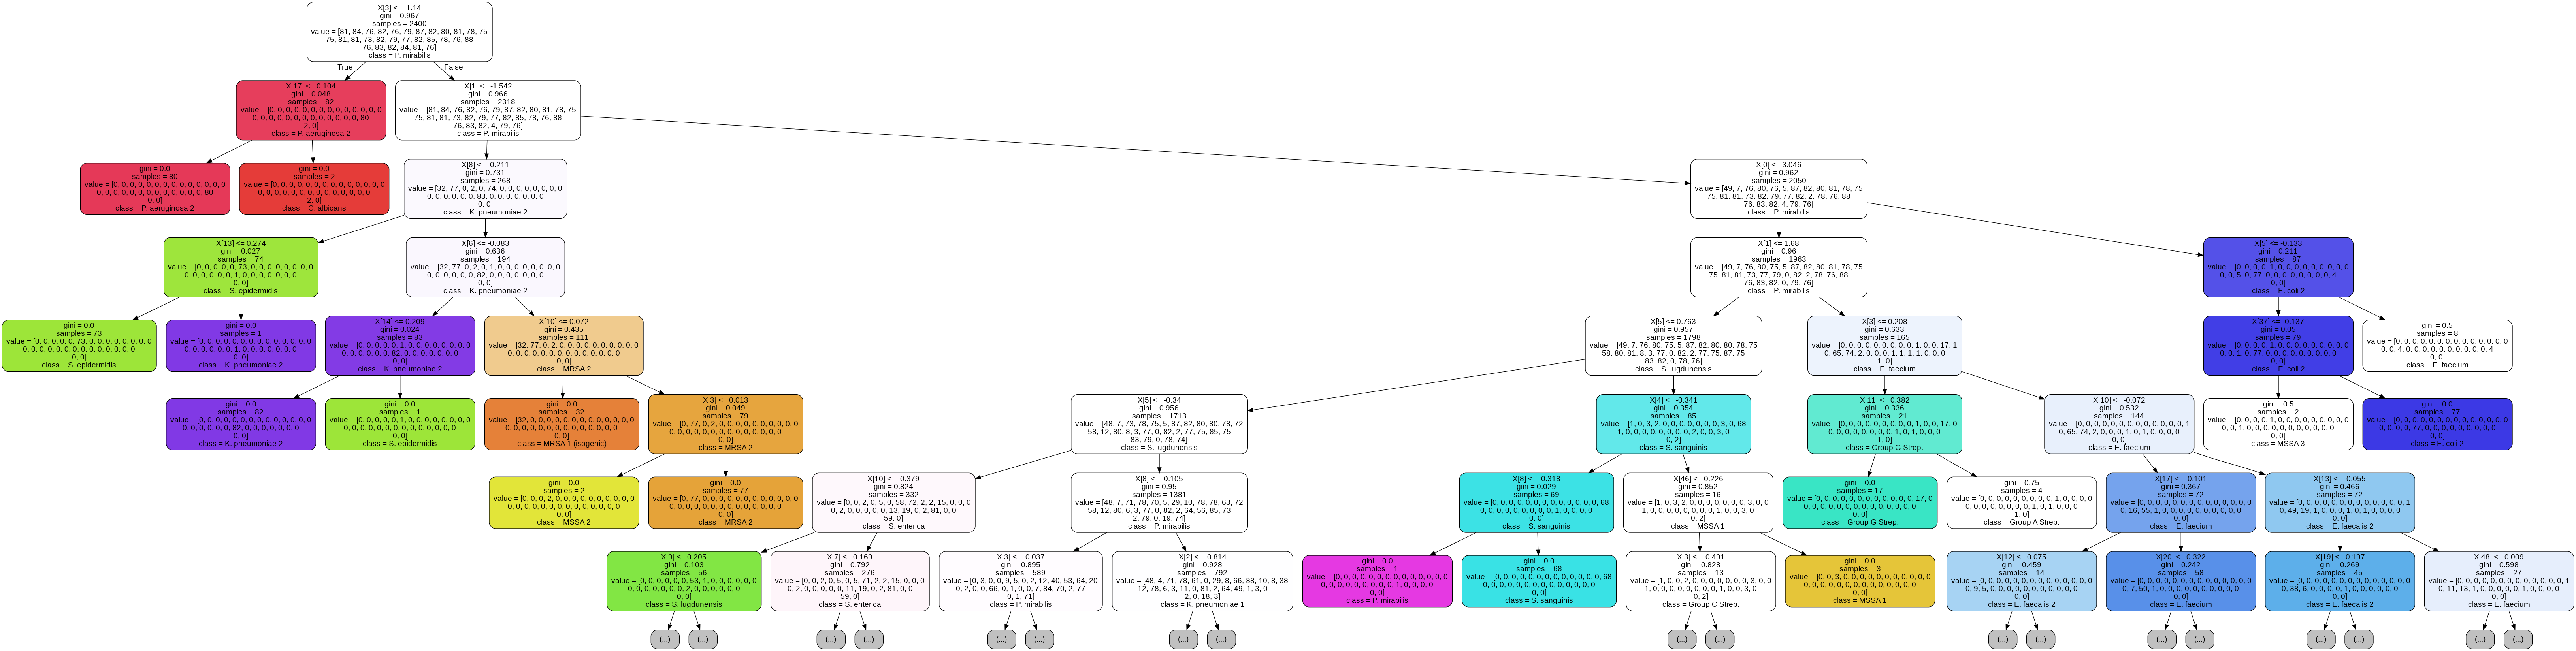

In [ ]:
# exportar el modelo a archivo .dot
label = [STRAINS[i] for i in ORDER]
with open(r"tree2.dot", 'w') as f:
     f = tree.export_graphviz(dtc_pca,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              class_names = label,
                              rounded = True,
                              filled= True )

# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree2.dot','-o',r'tree2.png'])
PImage("tree2.png")

### TreeCalsifier 

In [ ]:
name='DecisionTreeClassifier'

In [ ]:
# profundidad a 20 niveles
dtc =DecisionTreeClassifier(criterion= "gini" , max_depth=20,random_state=0, min_samples_split=10)

In [ ]:
# entrenamos
dtc=dtc.fit(X_tr, y_tr)
joblib.dump(dtc, 'modelo_dtc_entrenado.pkl')  # guardamos el modelo entrenado
dtc_tr_acc = dtc.score(X_tr,y_tr)
print('%s %s: %f'%(name,' Train ', dtc_tr_acc))

In [ ]:
# cargamos el modelo en caso de tenerlo almacenado
dtc = joblib.load('modelo_dtc_entrenado.pkl') 
dtc_tr_acc = dtc.score(X_tr,y_tr)
print('%s %s: %f'%(name,' Train ', dtc_tr_acc))

DecisionTreeClassifier  Train : 0.720812


In [ ]:
# predecimos con los datos de validación
y_dtc_val_pred = dtc.predict(X_val)
dtc_val_acc = accuracy_score(y_val, y_dtc_val_pred)
print('%s %s: %f'%(name,' Validacion ', dtc_val_acc))

DecisionTreeClassifier  Validacion : 0.391917


In [ ]:
# hacemos predicciones con los datos de ajuste fino pero entrenando con parte de ellos y validación con el resto
dtc.fit(X_ft_tr,y_ft_tr)
joblib.dump(dtc, 'modelo_dtc_entrenado_ft.pkl')  # guardamos el modelo entrenado
dtc_ft_tr_acc = dtc.score(X_ft_tr,y_ft_tr)
print('%s %s: %f'%(name,' FineTune Train ', dtc_ft_tr_acc))

DecisionTreeClassifier  FineTune Train : 0.789167


In [ ]:
# cargamos el modelo en caso de tenerlo almacenado
dtc = joblib.load('modelo_dtc_entrenado_ft.pkl') 
dtc_ft_tr_acc = dtc.score(X_ft_tr,y_ft_tr)
print('%s %s: %f'%(name,' FineTune Train ', dtc_ft_tr_acc))

DecisionTreeClassifier  FineTune Train : 0.789167


In [ ]:
# predecimos para los datos de validación para ajuste fino
y_dct_ft_val_pred=dtc.predict(X_ft_val)
dtc_ft_val_acc = accuracy_score(y_ft_val, y_dct_ft_val_pred)
print('%s %s: %f'%(name,' FineTune Validacion ', dtc_ft_val_acc))

DecisionTreeClassifier  FineTune Validacion : 0.308333


In [ ]:
# predecimos para los datos de test
y_dtc_test_pred = dtc.predict(X_test)
dtc_test_acc = accuracy_score(y_test, y_dtc_test_pred)
print('%s %s: %f'%(name,' Test ', dtc_test_acc))

DecisionTreeClassifier  Test : 0.264333


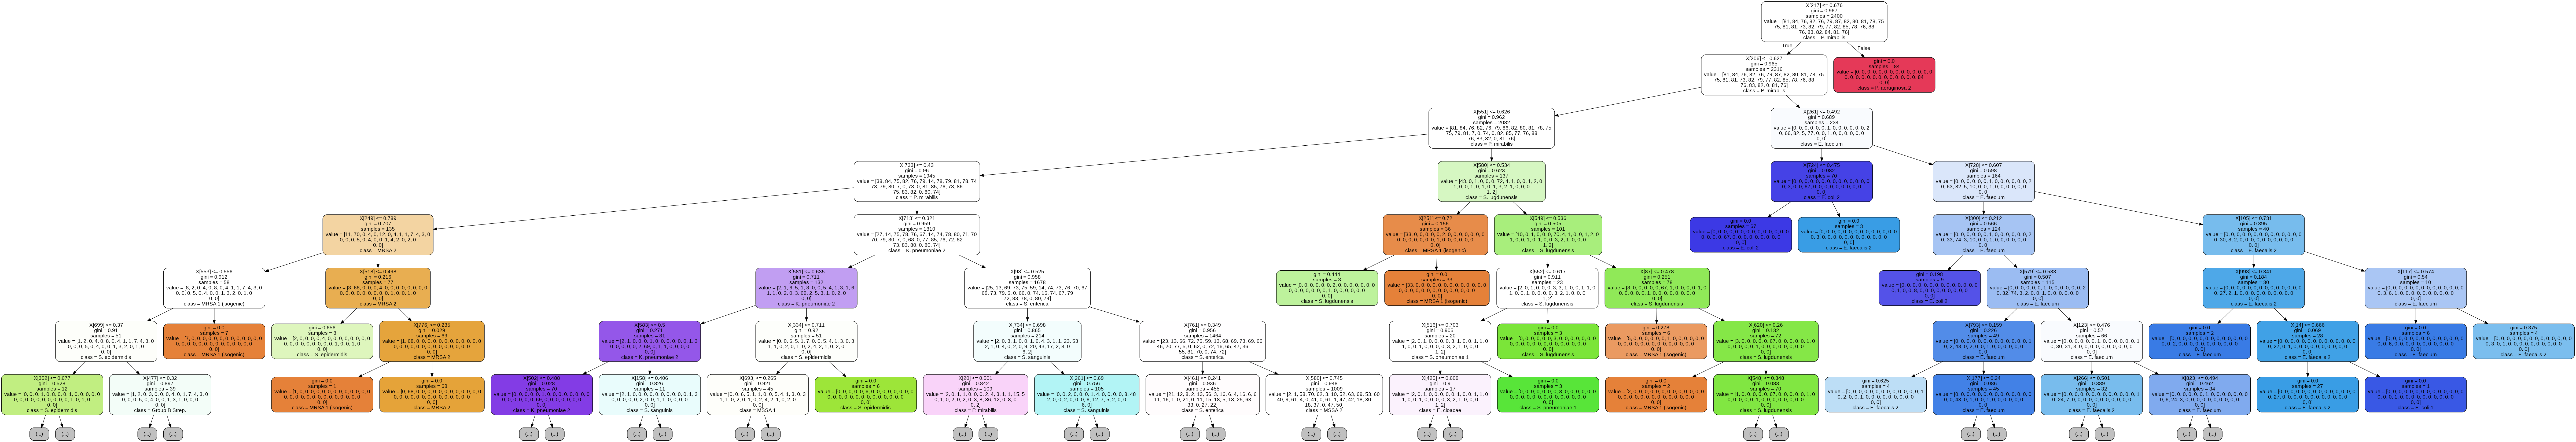

In [ ]:
# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(dtc,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              class_names = label,
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

## Generar modelo con RandomForest

### RandomFores con PCA

In [ ]:
# RandomForestClassifier de 10 a 310 árboles con un salto de 30
RFC_array = []
min_estimators = 10
max_estimators = 310

for i in range(min_estimators, max_estimators + 1, 30):
    rdfc = RandomForestClassifier(criterion='gini', max_depth=i, max_features='auto', min_samples_leaf=1, min_samples_split=10,random_state = 0, oob_score=True)
    rdfc.set_params(n_estimators=i)
    rdfc.fit(X_reduced_tr, y_tr)

    RFC_array.append((i, round(rdfc.score(X_reduced_val, y_val),5)))

xs, ys = zip(*RFC_array)



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


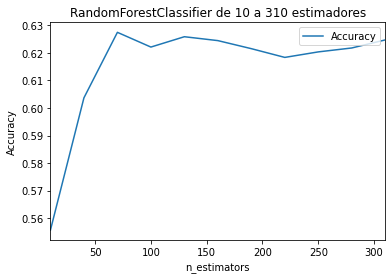

In [ ]:
plt.title('RandomForestClassifier de 10 a 310 estimadores')
plt.plot(xs, ys, label='Accuracy')
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()

In [ ]:
name='RandomForest + PCA'

In [ ]:
rdfc_pca = RandomForestClassifier(criterion='gini', max_depth=200, max_features='auto', min_samples_leaf=1, min_samples_split=10,random_state = 0, oob_score=True)
rdfc_pca.set_params(n_estimators=300)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# Entrenamos el modelo haciendo validación cruzada
rdfc_pca.fit(X_reduced_tr, y_tr)
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
rdfcpca_results = model_selection.cross_val_score(rdfc_pca, X_reduced_tr, y_tr, cv=kfold, scoring='accuracy')
joblib.dump(rdfc_pca, 'modelo_rdfc_pca_entrenado.pkl') # guardamos el modelo entrenado
rdfcpca_tr_acc = rdfcpca_results.mean()
print("%s %s: %f (%f)" % (name, ' Train ',rdfcpca_tr_acc, rdfcpca_results.std()))

In [ ]:
# cargamos el modelo en caso de tenerlo almacenado
rdfc_pca = joblib.load('modelo_rdfc_pca_entrenado.pkl') 
rdfcpca_tr_acc = rdfc_pca.score(X_reduced_tr,y_tr)
print('%s %s: %f'%(name,' Train ', rdfcpca_tr_acc))

RandomForest + PCA  Train : 0.940312


In [ ]:
rdfcpca_val_acc = rdfc_pca.score(X_reduced_val, y_val)
print('%s %s: %f'%(name,' Validacion ', rdfcpca_val_acc))

RandomForest + PCA  Validacion : 0.638083


In [ ]:
# hacemos predicciones con los datos de ajuste fino pero entrenando con parte de ellos y validación con el resto
rdfc_pca.fit(X_reduced_ft_tr,y_ft_tr)
seed = 7
kfold_ft = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
rdfcpca_results = model_selection.cross_val_score(rdfc_pca, X_reduced_ft_tr, y_ft_tr, cv=kfold_ft, scoring='accuracy')
joblib.dump(rdfc_pca, 'modelo_rdfc_pca_entrenado_ft.pkl') #guardamos el modelo entrenado
rdfcpca_ft_tr_acc = rdfcpca_results.mean()
msg = "%s %s: %f (%f)" % (name, 'FineTune Train ',rdfcpca_ft_tr_acc, rdfcpca_results.std())
print(msg)

In [ ]:
# cargamos el modelo en caso de tenerlo almacenado
rdfc_pca = joblib.load('modelo_rdfc_pca_entrenado_ft.pkl') 
rdfcpca_ft_tr_acc = rdfc_pca.score(X_reduced_ft_tr, y_ft_tr)
print('%s %s: %f'%(name,' FineTune Validacion ', rdfcpca_ft_tr_acc))

RandomForest + PCA  FineTune Validacion : 0.972917


In [ ]:
rdfcpca_ft_val_acc = rdfc_pca.score(X_reduced_ft_val, y_ft_val)
print('%s %s: %f'%(name,' FineTune Validacion ', rdfcpca_ft_val_acc))

RandomForest + PCA  FineTune Validacion : 0.675000


In [ ]:
rdfcpca_test_acc = rdfc_pca.score(X_reduced_test, y_test)
print('%s %s: %f'%(name,' Test ', rdfcpca_test_acc))

RandomForest + PCA  Test : 0.295333


### RandomForest

In [ ]:
name='RandomForest'

In [ ]:
rdfc = RandomForestClassifier(criterion='gini', max_depth=20, max_features='auto', min_samples_leaf=1, min_samples_split=10,random_state = 0, oob_score=True)
rdfc.set_params(n_estimators=300)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# entrenamos y mostramos los resultados
rdfc.fit(X_tr, y_tr)
joblib.dump(rdfc, 'modelo_rdfc_entrenado.pkl') # guardamos el modelo entrenado
rdfc_tr_acc = rdfc.score(X_tr,y_tr)
print('%s %s: %f'%(name,' Train ', rdfc_tr_acc))

In [ ]:
# Carga del modelo en caso de tenerlo almacenado y mostramos los resultados del entrenamiento
rdfc = joblib.load('modelo_rdfc_entrenado.pkl') 
rdfc_tr_acc = rdfc.score(X_tr,y_tr)
print('%s %s: %f'%(name,' Train ', rdfc_tr_acc))

RandomForest  Train : 0.999646


In [ ]:
rdfc_val_acc = rdfc.score(X_val, y_val)
print('%s %s: %f'%(name,' Validacion ', rdfc_val_acc))

RandomForest  Validacion : 0.730083


In [ ]:
# hacemos predicciones con los datos de ajuste fino pero entrenando con parte de ellos y validación con el resto
rdfc.fit(X_ft_tr,y_ft_tr)
joblib.dump(rdfc, 'modelo_rdfc_entrenado_ft.pkl') # guardamos el modelo entrenado
rdfc_ft_tr_acc = rdfc.score(X_ft_tr,y_ft_tr)
print('%s %s: %f'%(name,' FineTune Train ', rdfc_ft_tr_acc))

In [ ]:
# Carga del modelo ya entregado
rdfc = joblib.load('modelo_rdfc_entrenado_ft.pkl') 
rdfc_ft_tr_acc = rdfc.score(X_ft_tr,y_ft_tr)
print('%s %s: %f'%(name,' FineTune Train ', rdfc_ft_tr_acc))

RandomForest  FineTune Train : 1.000000


In [ ]:
rdfc_ft_val_acc = rdfc.score(X_ft_val, y_ft_val)
print('%s %s: %f'%(name,' FineTune Validacion ', rdfc_ft_val_acc))

RandomForest  FineTune Validacion : 0.698333


In [ ]:
rdfc_test_acc = rdfc.score(X_test, y_test)
print('%s %s: %f'%(name,' Test ', rdfc_test_acc))

RandomForest  Test : 0.583333


## Generar modelo con SVM

### SVM con PCA

In [ ]:
name='SVM PCA'

In [ ]:
svm_pca = SVC(random_state=0, probability=True, verbose=1)

In [ ]:
# hacemos validación cruzada
svm_pca.fit(X_reduced_tr,y_tr)
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
svmpca_results = model_selection.cross_val_score(svm_pca, X_reduced_tr, y_tr, cv=kfold, scoring='accuracy')
svmpca_tr_acc = svmpca_results.mean()
joblib.dump(svm_pca, 'modelo_svm_pca_entrenado.pkl') # guardamos el modelo
print("%s %s: %f (%f)" % (name, ' Train ',svmpca_tr_acc, svmpca_results.std()))

In [ ]:
# Carga del modelo ya entrenado y mostramos resultados de entrenamiento
svm_pca = joblib.load('modelo_svm_pca_entrenado.pkl') 

svmpca_tr_acc = svm_pca.score(X_reduced_tr,y_tr)
print('%s %s: %f'%(name,' Train ', svmpca_tr_acc))

SVM PCA  Train : 0.921604


In [ ]:
# hacemos las predicciones con los datos de validación
y_val_svmpca_pred = svm_pca.predict(X_reduced_val)
svmpca_val_acc = accuracy_score(y_val, y_val_svmpca_pred)
print('%s %s: %f'%(name,' Validacion ', svmpca_val_acc))

SVM PCA  Validacion : 0.610417


In [ ]:
# hacemos predicciones con los datos de ajuste fino pero entrenando con parte de ellos y validación con el resto
svm_pca.fit(X_reduced_ft_tr,y_ft_tr)
seed = 7
kfold_ft = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
svmpca_results = model_selection.cross_val_score(svm_pca, X_reduced_ft_tr, y_ft_tr, cv=kfold_ft, scoring='accuracy')
joblib.dump(svm_pca, 'modelo_svm_pca_entrenado_ft.pkl') # guardamos el modelo entrenado
svmpca_ft_tr_acc = svmpca_results.mean()
print("%s %s: %f (%f)" % (name, 'FineTune Train',svmpca_ft_tr_acc, svmpca_results.std()))

In [ ]:
# Carga del modelo ya entregado
svm_pca = joblib.load('modelo_svm_pca_entrenado_ft.pkl') 
# mostramos resultados de entrenamiento con fineTune
y_ft_tr_svmpca_pred=svm_pca.predict(X_reduced_ft_tr)
svmpca_ft_tr_acc = accuracy_score(y_ft_tr, y_ft_tr_svmpca_pred)
print('%s %s: %f'%(name,' FineTune Train ', svmpca_ft_tr_acc))

SVM PCA  FineTune Train : 0.915417


In [ ]:
# predecimos para los datos de validación para ajuste fino
y_ft_val_svmpca_pred=svm_pca.predict(X_reduced_ft_val)
svmpca_ft_val_acc = accuracy_score(y_ft_val, y_ft_val_svmpca_pred)
print('%s %s: %f'%(name,' FineTune Validacion ', svmpca_ft_val_acc))

SVM PCA  FineTune Validacion : 0.608333


In [ ]:
# predecimos para los datos de test
y_test_svmpca_pred=svm_pca.predict(X_reduced_test)
svmpca_test_acc = accuracy_score(y_test, y_test_svmpca_pred)
print('%s %s: %f'%(name,' Test ', dtc_test_acc))

SVM PCA  Test : 0.264333


### SVM 

In [ ]:
name='SVM'

In [ ]:
svm = SVC(random_state=0, probability=True, verbose=1)

In [ ]:
# entrenamos modelo y mostramos resultados
svm.fit(X_tr,y_tr)


[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=1)

In [ ]:
joblib.dump(svm, 'modelo_svm_entrenado.pkl') # guardamos modelo entrenado
svm_tr_acc = svm.score(X_tr,y_tr)
print('%s %s: %f'%(name,' Train ', svm_tr_acc))

SVM  Train : 0.984708


In [ ]:
# Carga del modelo ya entrenado
svm = joblib.load('modelo_svm_entrenado.pkl') 
svm_tr_acc = svm.score(X_tr,y_tr)
print('%s %s: %f'%(name,' Train ', svm_tr_acc))

SVM  Train : 0.984708


In [ ]:
# hacemos las predicciones con los datos de validación
y_val_svm_pred = svm.predict(X_val)
svm_val_acc = accuracy_score(y_val, y_val_svm_pred)
print('%s %s: %f'%(name,' Validacion ', svm_val_acc))

SVM  Validacion : 0.946167


In [ ]:
# hacemos predicciones con los datos de ajuste fino pero entrenando con parte de ellos y validación con el resto
svm.fit(X_ft_tr,y_ft_tr)
joblib.dump(svm, 'modelo_svm_entrenado_ft.pkl') # guardamos el modelo entrenado
svm_ft_tr_acc = svm.score(X_ft_tr,y_ft_tr)
print('%s %s: %f'%(name,' Train ', svm_ft_tr_acc))

[LibSVM]SVM  Train : 0.989583


In [ ]:
# Carga del modelo ya entrenado
svm = joblib.load('modelo_svm_entrenado_ft.pkl') 
svm_ft_tr_acc = svm.score(X_ft_tr,y_ft_tr)
print('%s %s: %f'%(name,' Train ', svm_ft_tr_acc))

In [ ]:
# predecimos para los datos de validación para ajuste fino
y_ft_val_svm_pred=svm.predict(X_ft_val)
svm_ft_val_acc = accuracy_score(y_ft_val, y_ft_val_svm_pred)
print('%s %s: %f'%(name,' FineTune Validacion ', svm_ft_val_acc))

SVM  FineTune Validacion : 0.878333


In [ ]:
# predecimos para los datos de test
y_test_svm_pred=svm.predict(X_test)
svm_test_acc = accuracy_score(y_test, y_test_svm_pred)
print('%s %s: %f'%(name,' Test ', svm_test_acc))

SVM  Test : 0.743667


## Preparar datos para Convoluciones

In [ ]:
# redimensionamos los datos para que en lugar de ser un vector lineal de 1000 datos cada característica esté separada
X_tr_cnn = np.reshape(X_tr,(X_tr.shape[0],1000,1))
y_tr_cnn = np.reshape(y_tr,(y_tr.shape[0],1))

X_val_cnn = np.reshape(X_val,(X_val.shape[0],1000,1))
y_val_cnn = np.reshape(y_val,(y_val.shape[0],1))

X_ft_tr_cnn = np.reshape(X_ft_tr,(X_ft_tr.shape[0],1000,1))
y_ft_tr_cnn = np.reshape(y_ft_tr,(y_ft_tr.shape[0],1))

X_ft_val_cnn = np.reshape(X_ft_val,(X_ft_val.shape[0],1000,1))
y_ft_val_cnn = np.reshape(y_ft_val,(y_ft_val.shape[0],1))

X_test_cnn = np.reshape(X_test,(X_test.shape[0],1000,1))
y_test_cnn = np.reshape(y_test,(y_test.shape[0],1))

In [ ]:
# preparación de etiquetas en 30 categorías.
n_classes = 30
y_tr_cnn_c = keras.utils.to_categorical(y_tr_cnn, n_classes)
y_v_cnn_c = keras.utils.to_categorical(y_val_cnn, n_classes)
y_f_tr_cnn_c = keras.utils.to_categorical(y_ft_tr_cnn, n_classes)
y_f_val_cnn_c = keras.utils.to_categorical(y_ft_val_cnn, n_classes)
y_t_cnn_c = keras.utils.to_categorical(y_test_cnn, n_classes)

## Generar modelo con ResNet

In [ ]:
# definimos los bloques identidad
def identity_block1(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2 = filters

    X_shortcut = X

    X = Conv1D(F1, 5, strides=1, padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(F2, 5, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2b')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
# definimos los bloques convolucionales
def convolutional_block1(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2 = filters

    X_shortcut = X

    X = Conv1D(F1, 5, strides=s, padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, epsilon=1e-05, momentum=0.1, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(F2, 5, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2b')(X)


    X_shortcut = Conv1D(F2, 1, strides=s, padding='same', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=2, epsilon=1e-05, momentum=0.1, name=bn_name_base + '1')(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
MR_input = Input((1000,1))
MR = Conv1D(64, 5, strides=1, name='convR1', padding='same', input_shape=(1000,1))(MR_input)
MR = BatchNormalization(axis=2, epsilon=1e-05, momentum=0.1, name='bn_convR1')(MR)
MR = Activation('relu')(MR)
MR = convolutional_block1(MR, f=2, filters=[64, 100], stage=2, block='a', s=1)
MR = identity_block1(MR, 2, [100, 100], stage=2, block='b')
MR = convolutional_block1(MR, f=2, filters=[100, 100], stage=3, block='a', s=1)
MR = identity_block1(MR, 2, [100, 100], stage=3, block='b')
MR = convolutional_block1(MR, f=2, filters=[100, 100], stage=4, block='a', s=1)
MR = identity_block1(MR, 2, [100, 100], stage=4, block='b')
MR = convolutional_block1(MR, f=2, filters=[100, 100], stage=5, block='a', s=1)
MR = identity_block1(MR, 2, [100, 100], stage=5, block='b')
MR = Flatten() (MR)
MR = Dense(500, activation='relu')(MR)
MR = Dropout(0.5)(MR)
MR = Dense(n_classes, activation='softmax') (MR)

In [ ]:
model_restnet = Model(inputs=MR_input, outputs=MR, name='RESTNET')

In [ ]:
model_restnet.summary()

Model: "RESTNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
convR1 (Conv1D)                 (None, 1000, 64)     384         input_1[0][0]                    
__________________________________________________________________________________________________
bn_convR1 (BatchNormalization)  (None, 1000, 64)     256         convR1[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1000, 64)     0           bn_convR1[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Set up Adam optimizer
optimizer = keras.optimizers.Adadelta(learning_rate=1e-3, rho=0.5, epsilon= 0.999)
model_restnet.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
batch_size = 10
epochs = 15 
model_restnet.fit(X_tr_cnn, y_tr_cnn_c,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_cnn, y_v_cnn_c))

Epoch 1/20
4800/4800 [==============================] - 740s 147ms/step - loss: 2.2116 - accuracy: 0.3754 - val_loss: 0.6361 - val_accuracy: 0.8023
Epoch 2/20
4800/4800 [==============================] - 703s 146ms/step - loss: 0.9819 - accuracy: 0.6796 - val_loss: 0.5160 - val_accuracy: 0.8436
Epoch 3/20
4800/4800 [==============================] - 703s 146ms/step - loss: 0.7626 - accuracy: 0.7463 - val_loss: 0.6035 - val_accuracy: 0.8561
Epoch 4/20
4800/4800 [==============================] - 703s 147ms/step - loss: 0.6210 - accuracy: 0.7970 - val_loss: 0.3085 - val_accuracy: 0.9022
Epoch 5/20
4800/4800 [==============================] - 704s 147ms/step - loss: 0.5252 - accuracy: 0.8292 - val_loss: 0.3486 - val_accuracy: 0.8966
Epoch 6/20
4800/4800 [==============================] - 705s 147ms/step - loss: 0.4558 - accuracy: 0.8510 - val_loss: 0.2763 - val_accuracy: 0.9097
Epoch 7/20
4800/4800 [==============================] - 702s 146ms/step - loss: 0.4056 - accuracy: 0.8679 - val_

In [ ]:
model_restnet.save('modelo_model_restnet_entrenado.h5')

In [ ]:
# Para el caso de volver a cargar el modelo
model_restnet = keras.models.load_model('modelo_model_restnet_entrenado.h5')

In [ ]:
name ='RestNet'

In [ ]:
scores_rest_tr = model_restnet.evaluate(X_tr_cnn, y_tr_cnn_c, verbose=0)
rest_tr_acc = scores_rest_tr[1]
print('%s %s: %f'%(name,' Train ', rest_tr_acc))

RestNet  Train : 0.987500


In [ ]:
scores_rest_val = model_restnet.evaluate(X_val_cnn, y_v_cnn_c, verbose=0)
rest_val_acc = scores_rest_val[1]
print('%s %s: %f'%(name,' Validacion ',rest_val_acc))

RestNet  Validacion : 0.930167


In [ ]:
# hacemos predicciones con los datos de ajuste fino pero entrenando con parte de ellos y validación con el resto
batch_size = 10
epochs = 15 
model_restnet.fit(X_ft_tr_cnn, y_f_tr_cnn_c,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_ft_val_cnn, y_f_val_cnn_c))

Epoch 1/15
240/240 [==============================] - 35s 148ms/step - loss: 1.3188 - accuracy: 0.6304 - val_loss: 0.6911 - val_accuracy: 0.7900
Epoch 2/15
240/240 [==============================] - 35s 147ms/step - loss: 0.8448 - accuracy: 0.7321 - val_loss: 0.5188 - val_accuracy: 0.8533
Epoch 3/15
240/240 [==============================] - 35s 147ms/step - loss: 0.6517 - accuracy: 0.7904 - val_loss: 0.4524 - val_accuracy: 0.8400
Epoch 4/15
240/240 [==============================] - 35s 147ms/step - loss: 0.5194 - accuracy: 0.8346 - val_loss: 0.4190 - val_accuracy: 0.8650
Epoch 5/15
240/240 [==============================] - 35s 147ms/step - loss: 0.4840 - accuracy: 0.8392 - val_loss: 0.3826 - val_accuracy: 0.8767
Epoch 6/15
240/240 [==============================] - 35s 147ms/step - loss: 0.4019 - accuracy: 0.8558 - val_loss: 0.3552 - val_accuracy: 0.8833
Epoch 7/15
240/240 [==============================] - 35s 147ms/step - loss: 0.3266 - accuracy: 0.8925 - val_loss: 0.3461 - val_ac

In [ ]:
model_restnet.save('modelo_model_restnet_entrenado_ft.h5')

In [ ]:
# Para el caso de volver a cargar el modelo
model_restnet = keras.models.load_model('modelo_model_restnet_entrenado_ft.h5')

In [ ]:
scores_rest_tr = model_restnet.evaluate(X_ft_tr_cnn, y_f_tr_cnn_c, verbose=0)
rest_ft_tr_acc = scores_rest_tr[1]
print('%s %s: %f'%(name,' FineTune Train ',rest_ft_tr_acc))

RestNet  FineTune Train : 0.999583


In [ ]:
scores_rest_val = model_restnet.evaluate(X_ft_val_cnn, y_f_val_cnn_c, verbose=0)
rest_ft_val_acc = scores_rest_val[1]
print('%s %s: %f'%(name,' FineTune Validacion ',rest_ft_val_acc))

RestNet  FineTune Validacion : 0.918333


In [ ]:
# predecimos para los datos de test
y_test_rest_pred = model_restnet.predict(X_test_cnn)
score_rest_test = model_restnet.evaluate(X_test_cnn, y_t_cnn_c, verbose=0)
rest_test_acc = score_rest_test[1]
print('%s %s: %f'%(name,' Test ',rest_test_acc))


RestNet  Test : 0.848333


## Genera modelo con CNN


### Generamos un modelo básico

In [ ]:
model_cnn0 = Sequential()
model_cnn0.add(Conv1D(filters=50,kernel_size=(10), padding='same', input_shape=(1000,1)))
model_cnn0.add(Conv1D(filters=20,kernel_size=(10), padding='same'))
model_cnn0.add(Flatten())
model_cnn0.add(Dense(30, activation='softmax'))
model_cnn0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1000, 50)          550       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 20)          10020     
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                600030    
Total params: 610,600
Trainable params: 610,600
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_cnn0.compile(loss='categorical_crossentropy',optimizer="adam",metrics=["accuracy"])
model_cnn0.fit(X_tr_cnn,y_tr_cnn_c,batch_size=20, epochs=5,validation_data=(X_val_cnn, y_v_cnn_c))

Epoch 1/5
2400/2400 [==============================] - 11s 4ms/step - loss: 0.9337 - accuracy: 0.7330 - val_loss: 0.2300 - val_accuracy: 0.9239
Epoch 2/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.2085 - accuracy: 0.9297 - val_loss: 0.2545 - val_accuracy: 0.9127
Epoch 3/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.1616 - accuracy: 0.9453 - val_loss: 0.2302 - val_accuracy: 0.9228
Epoch 4/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.1333 - accuracy: 0.9547 - val_loss: 0.2250 - val_accuracy: 0.9255
Epoch 5/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.1217 - accuracy: 0.9584 - val_loss: 0.2407 - val_accuracy: 0.9241


In [ ]:
model_cnn0.save('modelo_model_cnn0_entrenado.h5')

In [ ]:
# Para el caso de volver a cargar el modelo
model_cnn0 = keras.models.load_model('modelo_model_cnn0_entrenado.h5')

In [ ]:
name = 'CNN básica'
scores0_tr = model_cnn0.evaluate(X_tr_cnn, y_tr_cnn_c, verbose=0)
cnn0_tr_acc = scores0_tr[1]
print('%s %s: %f'%(name,' Train ', cnn0_tr_acc))

CNN básica  Train : 0.973833


In [ ]:
scores0_val = model_cnn0.evaluate(X_val_cnn, y_v_cnn_c, verbose=0)
cnn0_val_acc = scores0_val[1]
print('%s %s: %f'%(name,' Validacion ', cnn0_val_acc))

CNN básica  Validacion : 0.924083


In [ ]:
#re-entrenamos con los datos de ajuste fino
model_cnn0.fit(X_ft_tr_cnn, y_f_tr_cnn_c,batch_size=20, epochs=5,validation_data=(X_ft_val_cnn, y_f_val_cnn_c))

Epoch 1/5
120/120 [==============================] - 1s 10ms/step - loss: 1.0325 - accuracy: 0.7329 - val_loss: 0.5675 - val_accuracy: 0.8200
Epoch 2/5
120/120 [==============================] - 1s 7ms/step - loss: 0.3066 - accuracy: 0.8929 - val_loss: 0.4233 - val_accuracy: 0.8483
Epoch 3/5
120/120 [==============================] - 1s 7ms/step - loss: 0.1092 - accuracy: 0.9712 - val_loss: 0.3539 - val_accuracy: 0.8900
Epoch 4/5
120/120 [==============================] - 1s 7ms/step - loss: 0.0265 - accuracy: 0.9971 - val_loss: 0.3213 - val_accuracy: 0.9000
Epoch 5/5
120/120 [==============================] - 1s 7ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.3158 - val_accuracy: 0.9000


In [ ]:
# salvamos el modelo
model_cnn0.save('modelo_model_cnn0_entrenado_ft.h5')

In [ ]:
# Para el caso de volver a cargar el modelo
model_cnn0 = keras.models.load_model('modelo_model_cnn0_entrenado_ft.h5')

In [ ]:
scores0_tr_fn = model_cnn0.evaluate(X_ft_tr_cnn, y_f_tr_cnn_c, verbose=0)
cnn0_fn_tr_acc = scores0_tr_fn[1]
print('%s %s: %f'%(name,' FineTune Train ', cnn0_fn_tr_acc))

CNN básica  FineTune Train : 1.000000


In [ ]:
scores0_val_fn = model_cnn0.evaluate(X_ft_val_cnn, y_f_val_cnn_c, verbose=0)
cnn0_fn_val_acc = scores0_val_fn[1]
print('%s %s: %f'%(name,' FineTune Validacion ', cnn0_fn_val_acc))

CNN básica  FineTune Validacion : 0.900000


In [ ]:
# predecimos para los datos de test
score0 = model_cnn0.evaluate(X_test_cnn, y_t_cnn_c, verbose=0)
cnn0_test_acc =score0[1]
print('%s %s: %f'%(name,' Test ',  cnn0_test_acc))


CNN básica  Test : 0.828333


### Aumentamos el modelo

In [ ]:
model_cnn1 = Sequential()
model_cnn1.add(Conv1D(filters=128,kernel_size=(5), padding='same', input_shape=(1000,1),activation='relu'))
#model_cnn1.add(Dropout(0.5))

model_cnn1.add(Conv1D(filters=128,kernel_size=(5), padding='same',activation='relu'))
model_cnn1.add(Dropout(0.5))
model_cnn1.add(AveragePooling1D(pool_size=2))


model_cnn1.add(Conv1D(filters=32,kernel_size=(5), padding='same',activation='relu'))
#model_cnn1.add(AveragePooling1D(pool_size=2))
model_cnn1.add(Dropout(0.3))

model_cnn1.add(Flatten())
model_cnn1.add(Dense(512))
model_cnn1.add(Activation('relu'))
model_cnn1.add(Dropout(0.3))
model_cnn1.add(Dense(30, activation='softmax'))

model_cnn1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 1000, 128)         768       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1000, 128)         82048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 500, 128)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 500, 32)           20512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16000)            

In [ ]:
model_cnn1.compile(loss='categorical_crossentropy',optimizer="adam",metrics=["accuracy"])
model_cnn1.fit(X_tr_cnn,y_tr_cnn_c,batch_size=15, epochs=15,validation_data=(X_val_cnn, y_v_cnn_c))

Epoch 1/15
3200/3200 [==============================] - 43s 13ms/step - loss: 1.2999 - accuracy: 0.5969 - val_loss: 0.2475 - val_accuracy: 0.9197
Epoch 2/15
3200/3200 [==============================] - 42s 13ms/step - loss: 0.3885 - accuracy: 0.8647 - val_loss: 0.2054 - val_accuracy: 0.9286
Epoch 3/15
3200/3200 [==============================] - 42s 13ms/step - loss: 0.3244 - accuracy: 0.8859 - val_loss: 0.2115 - val_accuracy: 0.9315
Epoch 4/15
3200/3200 [==============================] - 42s 13ms/step - loss: 0.2937 - accuracy: 0.8980 - val_loss: 0.1840 - val_accuracy: 0.9377
Epoch 5/15
3200/3200 [==============================] - 42s 13ms/step - loss: 0.2700 - accuracy: 0.9050 - val_loss: 0.1668 - val_accuracy: 0.9435
Epoch 6/15
3200/3200 [==============================] - 42s 13ms/step - loss: 0.2602 - accuracy: 0.9077 - val_loss: 0.1761 - val_accuracy: 0.9426
Epoch 7/15
3200/3200 [==============================] - 42s 13ms/step - loss: 0.2423 - accuracy: 0.9165 - val_loss: 0.1749 -

In [ ]:
model_cnn1.save('modelo_model_cnn1_entrenado.h5')

In [ ]:
# Para el caso de volver a cargar el modelo
model_cnn1 = keras.models.load_model('modelo_model_cnn1_entrenado.h5')

In [ ]:
name = 'CNN ConvD1 DropOut'
scores1_tr = model_cnn1.evaluate(X_tr_cnn, y_tr_cnn_c, verbose=0)
cnn1_tr_acc = scores1_tr[1]
print('%s %s: %f'%(name,' Train ', cnn1_tr_acc))

CNN ConvD1 DropOut  Train : 0.973375


In [ ]:
scores1_val = model_cnn1.evaluate(X_val_cnn, y_v_cnn_c, verbose=0)
cnn1_val_acc = scores1_val[1]
print('%s %s: %f'%(name,' Validacion ', cnn1_val_acc))

CNN ConvD1 DropOut  Validacion : 0.940000


In [ ]:
#re-entrenamos con los datos de ajuste fino
model_cnn1.fit(X_ft_tr_cnn, y_f_tr_cnn_c,batch_size=20, epochs=5,validation_data=(X_ft_val_cnn, y_f_val_cnn_c))

Epoch 1/5
120/120 [==============================] - 3s 25ms/step - loss: 1.3411 - accuracy: 0.6363 - val_loss: 0.5644 - val_accuracy: 0.8083
Epoch 2/5
120/120 [==============================] - 3s 23ms/step - loss: 0.6945 - accuracy: 0.7629 - val_loss: 0.4106 - val_accuracy: 0.8767
Epoch 3/5
120/120 [==============================] - 3s 24ms/step - loss: 0.5274 - accuracy: 0.8338 - val_loss: 0.3496 - val_accuracy: 0.8967
Epoch 4/5
120/120 [==============================] - 3s 23ms/step - loss: 0.4571 - accuracy: 0.8537 - val_loss: 0.3221 - val_accuracy: 0.8983
Epoch 5/5
120/120 [==============================] - 3s 23ms/step - loss: 0.3884 - accuracy: 0.8671 - val_loss: 0.2986 - val_accuracy: 0.9050


In [ ]:
# salvamos el modelo
model_cnn1.save('modelo_model_cnn1_entrenado_ft.h5')

In [ ]:
# Para el caso de volver a cargar el modelo
model_cnn1 = keras.models.load_model('modelo_model_cnn1_entrenado_ft.h5')

In [ ]:
scores1_tr_fn = model_cnn1.evaluate(X_ft_tr_cnn, y_f_tr_cnn_c, verbose=0)
cnn1_fn_tr_acc = scores1_tr_fn[1]
print('%s %s: %f'%(name,' FineTune Train ', cnn1_fn_tr_acc))

CNN ConvD1 DropOut  FineTune Train : 0.947500


In [ ]:
scores1_val_fn = model_cnn1.evaluate(X_ft_val_cnn, y_f_val_cnn_c, verbose=0)
cnn1_fn_val_acc = scores1_val_fn[1]
print('%s %s: %f'%(name,' FineTune Validacion ', cnn1_fn_val_acc))

CNN ConvD1 DropOut  FineTune Validacion : 0.905000


In [ ]:
# predecimos para los datos de test
score1 = model_cnn1.evaluate(X_test_cnn, y_t_cnn_c, verbose=0)
cnn1_test_acc =score1[1]
print('%s %s: %f'%(name,' Test ',  cnn1_test_acc))


CNN ConvD1 DropOut  Test : 0.836000


### Nuevo modelo de CNN

In [ ]:

M_input = Input((1000,1))
M = Conv1D(64, 5, strides=1, name='conv1', padding='same', input_shape=(1000,1))(M_input)
M = BatchNormalization(axis=2, epsilon=1e-05, momentum=0.1, name='bn_conv1')(M)
M = Activation('relu')(M)
M = Conv1D(100, 5, strides=1, name='conv2', padding='same', input_shape=(1000,1))(M)
M = BatchNormalization(axis=2, epsilon=1e-05, momentum=0.1, name='bn_conv2')(M)
M = Activation('relu')(M)
M = Conv1D(100, 5, strides=1, name='conv3', padding='same', input_shape=(1000,1))(M)
M = BatchNormalization(axis=2, epsilon=1e-05, momentum=0.1, name='bn_conv3')(M)
M = Activation('relu')(M)
M = Flatten() (M)
M = Dense(500, activation='relu')(M)
M = Dropout(0.5)(M)
M = Dense(n_classes, activation='softmax') (M)

model_cnn2 = Model(inputs=M_input, outputs=M, name='CNN2')
model_cnn2.summary()



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 1000, 64)          384       
_________________________________________________________________
batch_normalization_3 (Batch (None, 1000, 64)          256       
_________________________________________________________________
activation_5 (Activation)    (None, 1000, 64)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1000, 100)         32100     
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000, 100)         400       
_________________________________________________________________
activation_6 (Activation)    (None, 1000, 100)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1000, 100)        

In [ ]:
# Set up Adam optimizer
optimizer = keras.optimizers.Adadelta(learning_rate=1e-3, rho=0.5, epsilon= 0.999)
model_cnn2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
batch_size = 10
epochs = 20 
model_cnn2.fit(X_tr_cnn, y_tr_cnn_c,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_cnn, y_v_cnn_c))

In [ ]:
model_cnn2.save('modelo_model_cnn2_entrenado.h5')

In [ ]:
# Para el caso de volver a cargar el modelo
model_cnn2 = keras.models.load_model('modelo_model_cnn2_entrenado.h5')

In [ ]:
name = 'CNN2 ConvD1'
scores2_tr = model_cnn2.evaluate(X_tr_cnn, y_tr_cnn_c, verbose=0)
cnn2_tr_acc = scores2_tr[1]
print('%s %s: %f'%(name,' Train ',  cnn2_tr_acc))

CNN2 ConvD1  Train : 0.999979


In [ ]:
scores2_val = model_cnn2.evaluate(X_val_cnn, y_v_cnn_c, verbose=0)
cnn2_val_acc = scores2_val[1]
print('%s %s: %f'%(name,' Validacion ',  cnn2_val_acc))

CNN2 ConvD1  Validacion : 0.947250


In [ ]:
# hacemos predicciones con los datos de ajuste fino pero entrenando con parte de ellos y validación con el res
batch_size = 10
epochs = 15 
model_cnn2.fit(X_ft_tr_cnn, y_f_tr_cnn_c,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_ft_val_cnn, y_f_val_cnn_c))

In [ ]:
# salvamos el modelo entrenado con ft
model_cnn2.save('modelo_model_cnn2_entrenado_ft.h5')

In [ ]:
# Para el caso de volver a cargar el modelo
model_cnn2 = keras.models.load_model('modelo_model_cnn2_entrenado_ft.h5')

In [ ]:
scores2_tr_fn = model_cnn2.evaluate(X_ft_tr_cnn, y_f_tr_cnn_c, verbose=0)
cnn2_fn_tr_acc = scores2_tr_fn[1]
print('%s %s: %f'%(name,' FineTune Train ',  cnn2_fn_tr_acc))

CNN2 ConvD1  FineTune Train : 1.000000


In [ ]:
scores2_val_fn = model_cnn2.evaluate(X_ft_val_cnn, y_f_val_cnn_c, verbose=0)
cnn2_fn_val_acc = scores2_val_fn[1]
print('%s %s: %f'%(name,' FineTune Validación ',  cnn2_fn_val_acc))

CNN2 ConvD1  FineTune Validación : 0.905000


In [ ]:
# predecimos para los datos de test
y_test_pred_c = model_cnn2.predict(X_test_cnn)
score2 = model_cnn2.evaluate(X_test_cnn, y_t_cnn_c, verbose=0)
cnn2_test_acc =score2[1]
print('%s %s: %f'%(name,' Test ',  cnn2_test_acc))


CNN2 ConvD1  Test : 0.851333


# Mostrar resultados

In [ ]:
scores = [[rlpca_tr_acc, rlpca_val_acc, rlpca_ft_tr_acc, rlpca_ft_val_acc, rlpca_test_acc]
         ,[rl_tr_acc, rl_val_acc, rl_ft_tr_acc, rl_ft_val_acc, rl_test_acc]
         ,[dtcpca_tr_acc, dtcpca_val_acc, dtcpca_ft_tr_acc, dtcpca_ft_val_acc, dtcpca_test_acc]
         ,[dtc_tr_acc, dtc_val_acc, dtc_ft_tr_acc, dtc_ft_val_acc, dtc_test_acc]
         ,[rdfcpca_tr_acc, rdfcpca_val_acc, rdfcpca_ft_tr_acc, rdfcpca_ft_val_acc, rdfcpca_test_acc]
         ,[rdfc_tr_acc, rdfc_val_acc, rdfc_ft_tr_acc, rdfc_ft_val_acc, rdfc_test_acc]
         ,[svmpca_tr_acc, svmpca_val_acc, svmpca_ft_tr_acc, svmpca_ft_val_acc, svmpca_test_acc]
         ,[svm_tr_acc, svm_val_acc, svm_ft_tr_acc, svm_ft_val_acc, svm_test_acc]
         ,[rest_tr_acc, rest_val_acc, rest_ft_tr_acc, rest_ft_val_acc, rest_test_acc]
         ,[cnn0_tr_acc, cnn0_val_acc, cnn0_fn_tr_acc, cnn0_fn_val_acc, cnn0_test_acc]
         ,[cnn1_tr_acc, cnn1_val_acc, cnn1_fn_tr_acc, cnn1_fn_val_acc, cnn1_test_acc]
         ,[cnn2_tr_acc, cnn2_val_acc, cnn2_fn_tr_acc, cnn2_fn_val_acc, cnn2_test_acc]
          ]
df_scores = pd.DataFrame(scores , index =['Logistic Regresion PCA', 'Logistic Regresion','Decision Tree PCA','Decision Tree'
                        , 'RandomForest PCA', 'RandomForest', 'SVM PCA', 'SVM'
                        , 'RestNet', 'CNN ConvD1 Básica ', 'CNN1 ConvD1 DropOut', 'CNN2 ConvD1']
                        , columns = ['Accuracy Train', 'Accuracy Val', 'Accuracy FineTune Train', 'Accuracy FineTune Val','Accuracy Test'])
df_scores.to_csv('df_scores.csv', header=False, index=False)
df_scores



,Accuracy Train,Accuracy Val,Accuracy FineTune Train,Accuracy FineTune Val,Accuracy Test
Logistic Regresion PCA,0.834271,0.552000,0.878333,0.550000,0.223667
Logistic Regresion,0.971167,0.912667,1.000000,0.898333,0.782000
Decision Tree PCA,0.784729,0.377583,0.843750,0.490000,0.147333
Decision Tree,0.720812,0.391917,0.789167,0.308333,0.264333
RandomForest PCA,0.940312,0.638083,0.972917,0.675000,0.295333
RandomForest,0.999646,0.730083,1.000000,0.698333,0.583333
SVM PCA,0.921604,0.610417,0.915417,0.608333,0.285333
SVM,0.984708,0.946167,0.989583,0.878333,0.743667
RestNet,0.987500,0.930167,0.999583,0.918333,0.848333
CNN ConvD1 Básica,0.973833,0.924083,1.000000,0.900000,0.828333


In [ ]:
# preparación de etiquetas en 30 categorías.
y_test_pred = argmax(y_test_pred_c, axis=1)

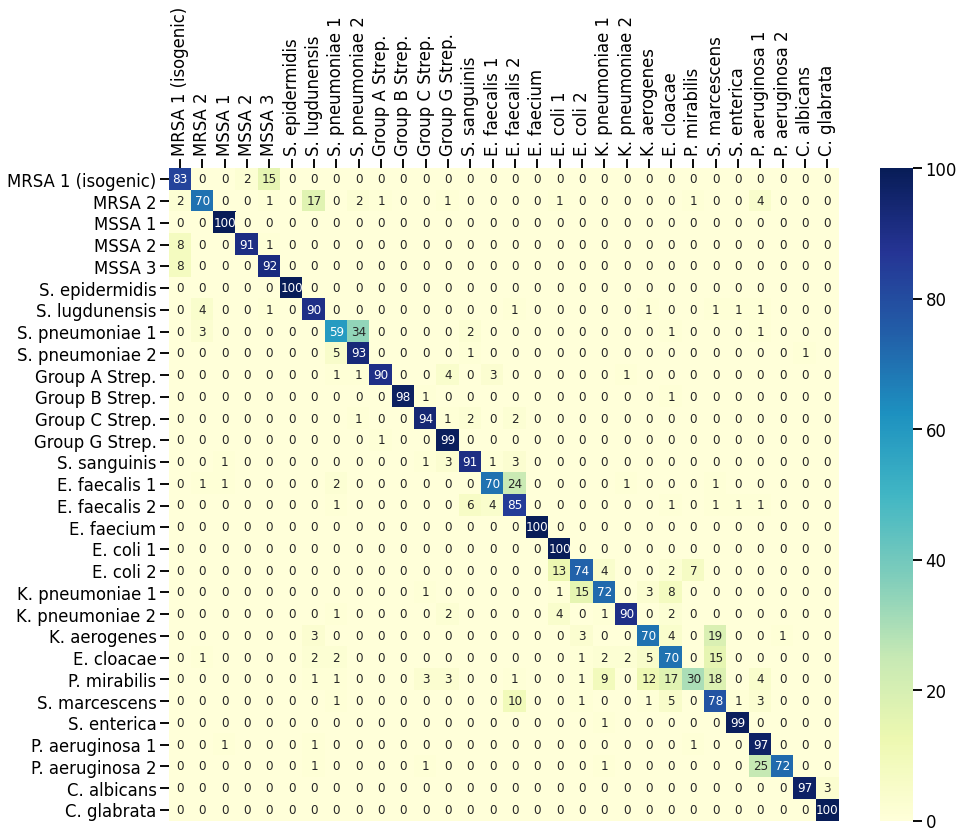

In [ ]:
# Matriz de confusión
sb.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [STRAINS[i] for i in ORDER]
cm = confusion_matrix(y_test, y_test_pred, labels=ORDER)
plt.figure(figsize=(15, 12))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sb.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

In [ ]:
# Asociamos a cada bacteria el tipo de antibiótico
y_test_ab = np.asarray([ATCC_GROUPINGS[i] for i in y_test])
y_test_ab_pred = np.asarray([ATCC_GROUPINGS[i] for i in y_test_pred])

# Computing accuracy
acc_ab = (y_test_ab_pred == y_test_ab).mean()
print('Accuracy: {:0.1f}%'.format(100*acc_ab))

Accuracy: 97.0%


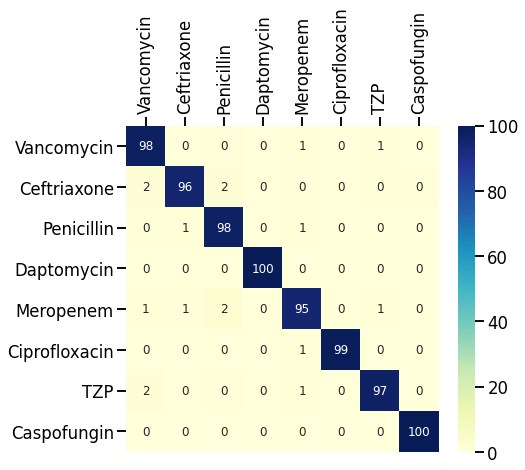

In [ ]:
# Matriz de confusión
sb.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [antibiotics[i] for i in ab_order]
cm = confusion_matrix(y_test_ab, y_test_ab_pred, labels=ab_order)
plt.figure(figsize=(7, 6))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sb.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

**Conclusiones**

En el trabajo se han mostrado distintos modelos para la identificación de bacterias utilizando espectroscopía Raman.

Para los modelos de Regresión logística, Árboldes de Decisión, RandomForest y SVM se ha utilizado reducción de dimensionalidad con PCA, y los resultados muestran que el modelo ajusta en los datos de entrenamiento, tanto de referencia como de FineTune, pero no se ajusta ni en validación ni en test, lo cual indica. Además los resultado en test en ninguno de los modelos utilizando PCA supera el 30% de accuracy.

Los resultados de los modelos sin utilizar la técnica de PCA muestran en general, mayor ajuste. En particular los Árboles de Decisión no tienen buen rendimiento, no llegando a 80% en entrenamiento y 30% en test. De igual forma RandomForest su rendimiento no supera el 60% en test. Regresión Logistica y SVM alcanzan el 78% y 74% respectivamente, pero no consiguen superar el 82% del estudio.

Respecto a los modelos de redes convolucionales sí superan una precisión del 82% en test, siendo el modelo de ResNet y la red convolucional con tres capas convolucionales sin Dropout los que mejor resultado muestran, 84,8% y 85% respectivamente. Hay que señalar que el modelo ResNet es más complejo y con mayor número de parámetros, y el tiempo en el entramiento y ejecución son muy superiores a la de la red CNN.

Por todo ello se considera como el modelo elegido la red CNN mejorada con una precisión de 85% en la clasificación de bacterias y el 97% en la clasificación tratamiento de antibiótico.